# Projet :  nouvelles constructions en France

### Table of Contents
* <a href='#packages'>Import Packages</a>
* <a href='#functions'>Functions</a>
* <a href='#issue'>Issue</a>
* [Data](#data)
* [Part I: Regional Scale](#part_1)
    * [Group by region](#part_1_1)
    * [Graphic and Analysis](#part_1_2)
* [Partie II: Departmental Scale](#part_2)
    * [Number of building permits by department](#part_2_1)
    * [Top 10 departments with the most building permits](#part_2_2)
    * [Filter to keep only individual building permits ](#part_2_3)
    * [Departments of origin of applicants](#part_2_4)
    * [Graphic and Analysis](#part_2_5)
* [Partie III: Case study on urban extension in Loire-Atlantique](#part_3)
    * [Number of building permits by department](#part_2_1)
    * [Top 10 departments with the most building permits](#part_2_2)
    * [Filter to keep only individual building permits ](#part_2_3)
    * [Departments of origin of applicants](#part_2_4)
    * [Graphic and Analysis](#part_2_5)

## <a id='packages'> Import Packages </a>

In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import geopandas as gpd 
import pysal as ps 
import contextily as cx
import plotly.express as px
import matplotlib.colors as colors

C:\Users\Thomas\Anaconda3\envs\geo\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\Thomas\Anaconda3\envs\geo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Thomas\Anaconda3\envs\geo\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## <a id='functions'>Functions </a>

In [2]:
def com_code(code, dep):
    if len(str(code))==1:
        code="00"+str(code)
    if len(str(code))==2:
        code="0"+str(code)
    code=str(dep)+ str(code)
    return code

In [3]:
def moran_cluster(index_moran):
    kind_cluster='non_significant'
    if index_moran==1:
        kind_cluster='HH'
    elif index_moran==2:
        kind_cluster='LH'
    elif index_moran==3:
        kind_cluster='LL'
    elif index_moran==4:
        kind_cluster='HL'
    return kind_cluster

## Issue <a class="anchor" id="issue"></a>

<b> Where do we build the most in France? </b>

To answer this question, three scales were studied:

-regional

-departmental

-and a more precise case study for the department that was identified as the one where the most construction is taking place: Loire-Atlantique


## Data <a class="anchor" id="data"></a>

The data used are from the sitadel database which lists all the construction projects in France, it is made available in the form of a csv file.
<br> We have decided to base ourselves on the year 2021. </br>

source: https://www.statistiques.developpement-durable.gouv.fr/construction-de-logements-resultats-fin-avril-2022-france-entiere?rubrique=&dossier=1047

In [4]:
sitadel=pd.read_csv('PC_DP_créant_logements_2021.txt', sep='\t', encoding='latin-1', low_memory=False)

In [5]:
sitadel.head()

REG DEP  COMM Type_DAU        Num_DAU  Etat_DAU DATE_REELLE_AUTORISATION  \
0   82   1  1001       PC  00100120V0010         2               18/01/2021   
1   82   1  1001       PC  00100121V0001         5               16/03/2021   
2   82   1  1001       PC  00100121V0002         2               02/04/2021   
3   82   1  1001       PC  00100121V0003         2               26/04/2021   
4   82   1  1001       PC  00100121V0004         5               12/05/2021   

  DATE_REELLE_DOC DATE_REELLE_DAACT  DPC_AUT  ... SURF_HAB_AVANT  \
0             NaN               NaN   202101  ...            0.0   
1      28/06/2021               NaN   202103  ...            0.0   
2             NaN               NaN   202104  ...            0.0   
3             NaN               NaN   202104  ...            0.0   
4      25/11/2021               NaN   202105  ...            0.0   

   SURF_HAB_CREEE  SURF_HAB_ISSUE_TRANSFO SURF_HAB_DEMOLIE  \
0            92.0                     0.0              0.0   
1           112.0                     0.0              0.0   
2             0.0                   142.0              0.0   
3           105.0                     0.0              0.0   
4           103.0                     0.0              0.0   

  SURF_HAB_TRANSFORMEE SURF_LOC_AVANT SURF_LOC_CREEE SURF_LOC_ISSUE_TRANSFO  \
0                  0.0              0              0                      0   
1                  0.0              0              0                      0   
2                  0.0            142              0                      0   
3                  0.0              0              0                      0   
4                  0.0              0              0                      0   

  SURF_LOC_DEMOLIE SURF_LOC_TRANSFORMEE  
0                0                    0  
1                0                    0  
2                0                  142  
3                0                    0  
4                0                    0  

[5 rows x 67 columns]

## Part I: Regional Scale <a class="anchor" id="part_1"></a>

### Group by region <a class="anchor" id="part_1_1"></a>

We have grouped the data by region for comparison 

In [6]:
reg_sitadel=sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).count()

In [7]:
reg_sitadel['REG']=reg_sitadel['REG'].apply(str)

In [8]:
reg_sitadel['REG']=reg_sitadel['REG'].replace({'1': 'Guadeloupe', '2': 'Martinique', '3': 'Guyane', '4': 'La Reunion','6':'Mayotte', 
                         '11': 'Ile-de-France', '21': 'Grand Est','22': 'Haut-de-France', '23':'Normandie', 
                         '24':'Centre-Val-de-Loire','25': 'Normandie', '26':'Bourgogne-France-Comté', 
                         '31': 'Haut-de-France','41':'Grand Est', '42': 'Grand Est',
                         '43':'Bourgogne-France-Comté', '52': 'Pays de la Loire', '53':'Bretagne',
                        '54':'Nouvelle-Aquitaine', '72':'Nouvelle-Aquitaine', '73':'Occitanie',
                        '74':'Nouvelle-Aquitaine', '82':'Auvergne-Rhone-Alpes', '83':'Auvergne-Rhone-Alpes',
                        '91': 'Occitanie', '93':'Rhone-Alpes-Cote-Azur', '94': 'Corse'})

In [9]:
reg_sitadel=reg_sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).sum()

In [10]:
reg_sitadel=reg_sitadel.sort_values(by=['Num_DAU'], ascending=True)

### Graphic and Analysis <a class="anchor" id="part_1_2"></a>

In [11]:
fig = px.bar(reg_sitadel, x='REG', y='Num_DAU',  color='REG',
             title="Number of new buildings by region in France in 2021",
             width=1200, height=800,
            labels={
                     "Num_DAU": "Number of constructions",
                     "REG": "Regions",
                 })



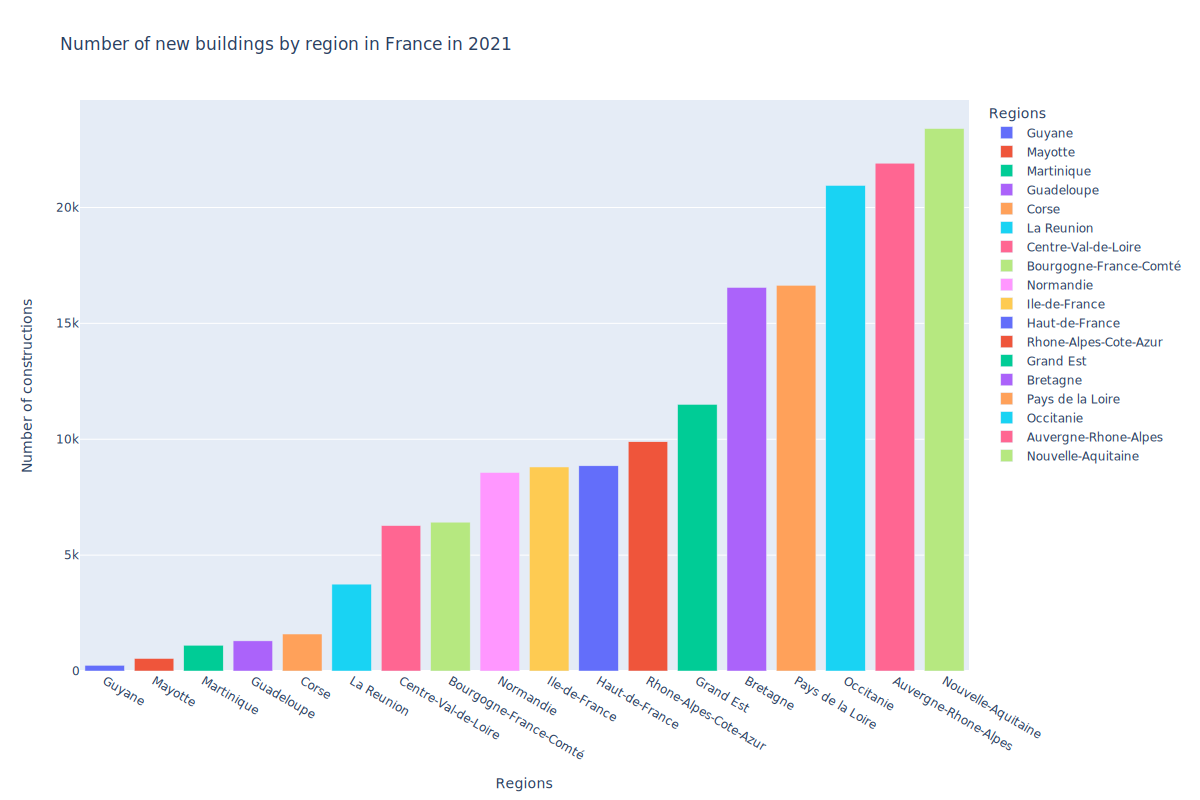

In [12]:
fig.show(renderer="svg")

the regions can be divided into three categories: 
<ul>
<li>very dynamic regions with more than 20,000 constructions in 2021: Nouvelle Aquitaine, Auvergne-Rhône-Alpes and Occitanie</li> 
<li>A second group with a significant number of new constructions around 16,000 in 2021: Pays de la Loire and Bretagne </li>   
<li>and the rest of the regions where the number of new constructions is less than 10,000 in 2021 (except for the Grand Est with a slightly higher figure)</li>
</ul>

## Partie II: Departmental Scale <a class="anchor" id="part_2"></a>

### Number of building permits by department <a class="anchor" id="part_2_1"></a>

In [13]:
departement_sitadel=sitadel[['DEP', 'Num_DAU']].groupby(['DEP'], as_index=False).count()

### Top 10 departments with the most building permits <a class="anchor" id="part_2_2"></a>

In [14]:
dep_top=departement_sitadel.sort_values(by=['Num_DAU'], ascending=False).head(10)

In [15]:
dep_top['rank']=dep_top['Num_DAU'].rank(ascending=False, method='min')

In [16]:
dep_top10=dep_top['DEP'].tolist()

### Filter to keep only individual building permits <a class="anchor" id="part_2_3"></a>

In [17]:
sitadel_part=sitadel[sitadel['CAT_DEM'].isin([10,11,12])].copy()

In [18]:
print("the percentage of individual building permits is: " + str(round(len(sitadel_part)/len(sitadel), 2)))

the percentage of individual building permits is: 0.87


### Departments of origin of applicants <a class="anchor" id="part_2_4"></a>

In [19]:
sitadel_part['DEP_D']=sitadel_part.CODPOST_DEM.str[:2]

In [20]:
dep_origine=sitadel_part[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).count()

In [21]:
dep_origine=dep_origine[dep_origine['DEP'].isin(dep_top10)].copy()

In [22]:
dep_origine['DEP_D']=np.where(dep_origine['DEP']==dep_origine['DEP_D'], 'from the department', dep_origine['DEP_D'])
dep_origine['DEP_D']=np.where((dep_origine['DEP']=='974') & (dep_origine['DEP_D']=='97'), 'from the department', dep_origine['DEP_D'])

In [23]:
dep_origine['DEP_D']=np.where(dep_origine['DEP_D']=='from the department', dep_origine['DEP_D'], 'other')

In [24]:
dep_origine=dep_origine[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).sum()

### Graphic and Analysis <a class="anchor" id="part_2_5"></a>

In [25]:
order=dep_origine.groupby('DEP', as_index=False).sum().sort_values('Num_DAU')
order['rank']=order['Num_DAU'].rank()

In [26]:
dep_origine['rank']=dep_origine['DEP'].map(order.set_index('DEP')['rank'])
dep_origine=dep_origine.sort_values(by=['rank','DEP_D'], ascending=[True,False])

In [27]:
fig = px.bar(dep_origine, x="DEP", y="Num_DAU", color="DEP_D", 
             title="Number of new buildings in the 10 departments with the most construction in France in 2021",
            width=1000, height=600,
            labels={
                     "Num_DAU": "Number of constructions",
                     "DEP": "Department number",
                     "DEP_D": "Origin of the owner"
                 },
            color_discrete_map={
        'other': '#696969',
        'from the department': '#6495ED'})

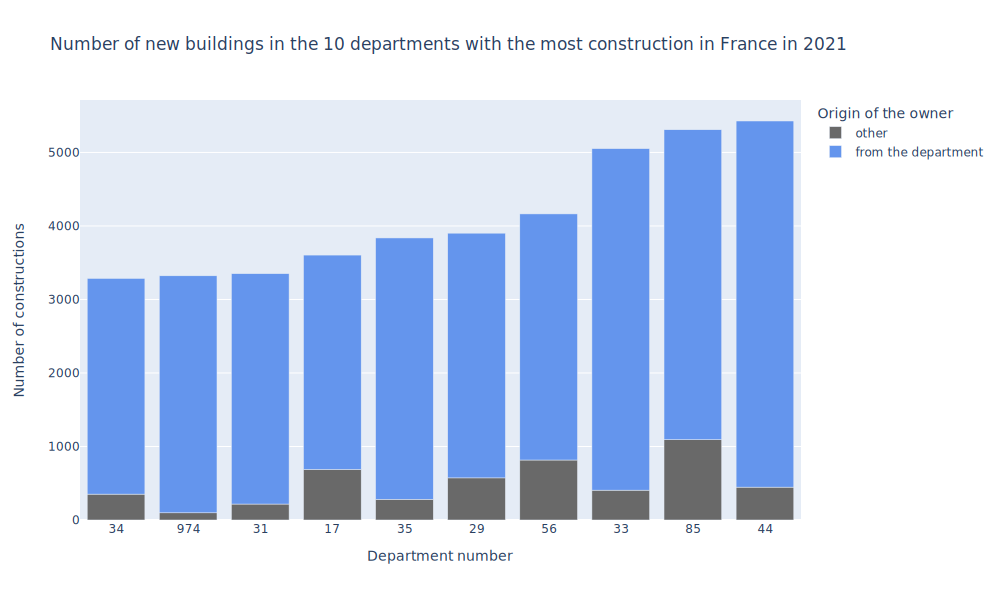

In [28]:
fig.show(renderer="svg")

For the 10 departments with the most constructions, 9 are coastal departments. More precisely, the 6 departments between Finistère and Gironde are all present in this top, so there is a very strong dynamic of the Atlantic coast.

We can also note the presence of 3 of the 4 Breton departments, which can be partly explained by the opening up of this region thanks to the creation of several TGV lines and a particularly attractive fiber coverage.

## Partie III: Case study on urban extension in Loire-Atlantique <a class="anchor" id="part_3"></a>

### Création d'un Geodataframe

In [29]:
dep_44=gpd.read_file(r'communes-loire-atlantique.geojson')


In [30]:
dep_44['geometry']=dep_44['geometry'].simplify(0.001)

### nombre de constructions par commune

In [31]:
com_sitadel=sitadel[['COMM', 'Num_DAU']].groupby(['COMM'], as_index=False).count()
##dep_sitadel01 = dep_sitadel01[dep_sitadel01['COMM'].str.startswith('01')] 

### jointure pour cartographie

In [32]:
dep_44=dep_44.merge( com_sitadel, left_on='code_insee', right_on='COMM', how='left')
dep_44['Num_DAU'] = dep_44['Num_DAU'].fillna(0)

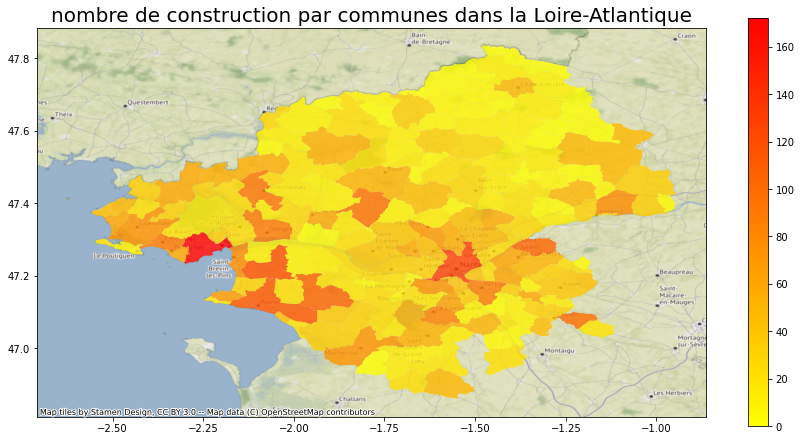

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=dep_44.plot(ax=ax, column='Num_DAU',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par communes dans la Loire-Atlantique", fontdict={'fontsize': 20, 'fontweight': 'medium'} )
cx.add_basemap(ax, crs=dep_44.crs)


In [34]:
dep_44.index=dep_44.libelle_long_norm
dep_44.index= dep_44.index.rename('commune')

### Nombre de nouvelles construction par nombre d'habitant

In [35]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')

In [36]:
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))

In [37]:
dep_44=dep_44.merge( recensement_44, left_on='code_insee', right_on='code_com', how='left')

In [38]:
dep_44['con_by_h']=dep_44['Num_DAU']/dep_44['Population totale']*100

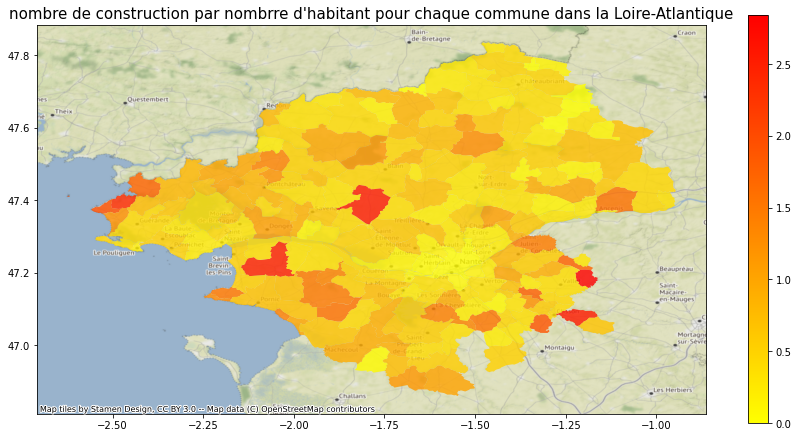

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=dep_44.plot(ax=ax, column='con_by_h',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par nombrre d'habitant pour chaque commune dans la Loire-Atlantique", fontdict={'fontsize': 15, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44.crs)

Il est difficile de tirer une conclusion et d'extraire des dynamiques territoriales avec une approche quantitative.
Nous allons donc utiliser l'indice de Moran local qui permet d'identifier les zones de cluster.
La démarche que nous allons suivre est tirée de deux sources:

-cette article de l'insee: https://www.insee.fr/fr/statistiques/fichier/3635442/imet131-g-chapitre-3.pdf

-et cette conférence D'Anselin, fondateur de l'économétrie spatiale: https://www.youtube.com/watch?v=d1WJNBwXfgo&list=PLzREt6r1Nenkr2vtYgbP4hs44HO_s_qEO&index=4


### indice de moran
<br>
### variable étudiée

#### preparation des donnees

In [40]:
dep_44=dep_44.to_crs('EPSG:2154')

In [41]:
y=dep_44['Num_DAU']

In [42]:
o=ps.lib.weights.KNN.from_dataframe(dep_44, geom_col='geometry', k=10)
    

### calcul indice de moran global

In [43]:
m=ps.explore.esda.Moran(y, o, transformation='r')

### indice de moran global 

In [44]:
print('moran global')
print(m.I)

moran global
0.1597764841542399


### Indice de moran local

In [45]:
o

In [46]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

## valeurs locales de Moran

In [47]:
dep_44['index_moran_classe']=m_local.q
dep_44['index_moran']=m_local.Is

### test de l'hypothèse de randomisation 

In [48]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


### False Discovery Rate

In [49]:
test=ps.explore.esda.fdr(dep_44['p_value'], 0.10)
dep_44['index_moran_cluster']=dep_44['index_moran_classe'].where(dep_44['p_value'] <= test).fillna(0)

### Cartographie des Clusters
(HH: high high, HL: High Low, LH: Low Hig, LL: Low Low)

In [50]:
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].apply(lambda x: moran_cluster(x))

In [51]:
color_dict = {'LL':'#b82e2e', 'LH':'#FC6955', 'HL':'#3283FE', 
              'HH':'#1223e0', 'non_significant':'#bab0ac'}

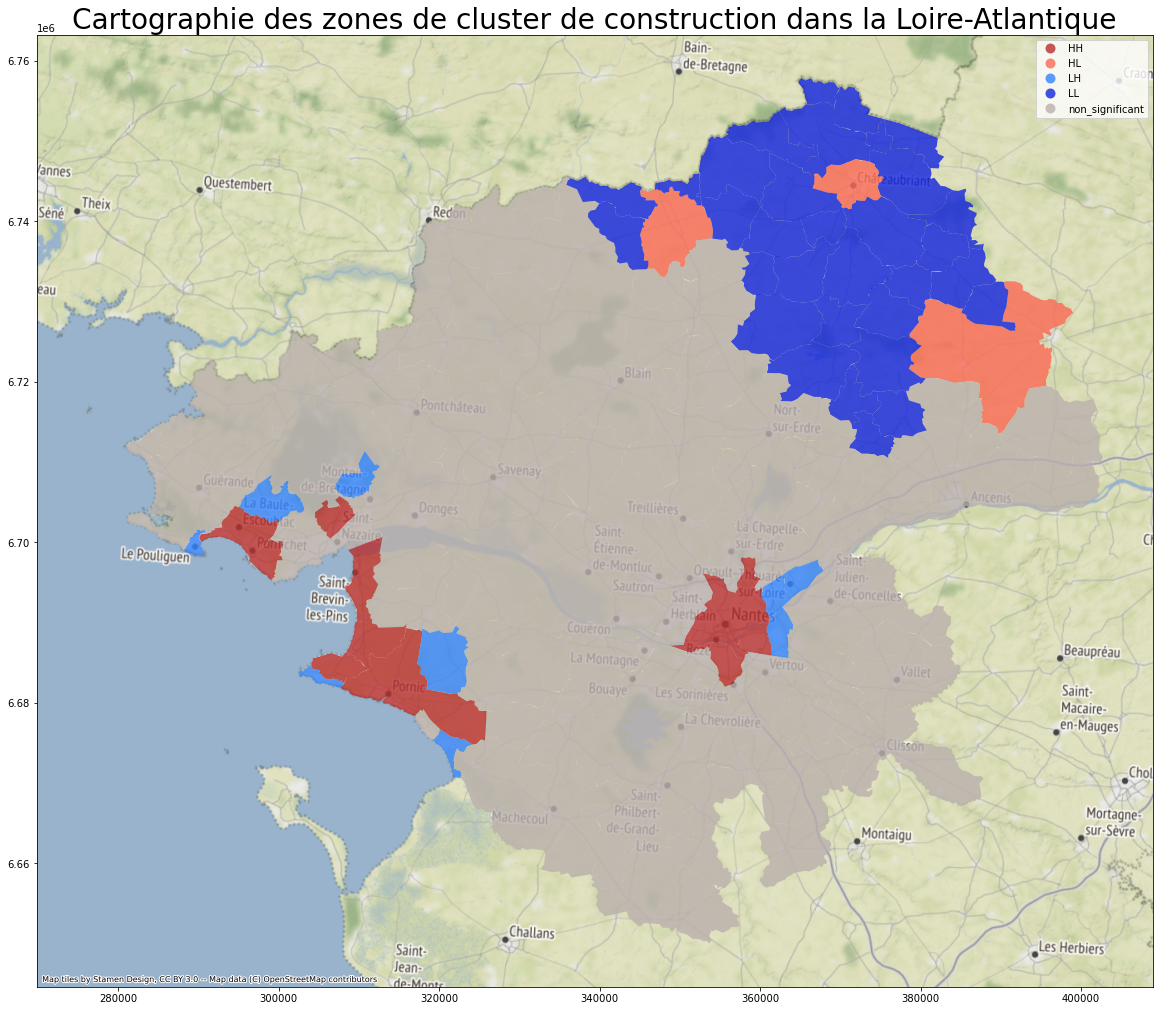

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans la Loire-Atlantique", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44.crs)


## Adding Vendee in the analysis

### data structuration

In [53]:
dep_85=gpd.read_file(r'communes-17-charente-maritime.geojson')
dep_85=dep_85[['com_code', 'com_name', 'geometry' ]].copy()
dep_85=dep_85.rename(columns={'com_code':'code', 'com_name':'nom'})
dep_85=dep_85.to_crs('EPSG:2154')


In [54]:
dep_44=dep_44[['code_insee', 'libelle_long_norm', 'geometry']].copy()
dep_44=dep_44.rename(columns={'code_insee':'code', 'libelle_long_norm':'nom'})

In [55]:
dep_44_85=pd.concat([dep_44, dep_85])

In [56]:
dep_44_85=dep_44_85.merge( com_sitadel, left_on='code', right_on='COMM', how='left')
dep_44_85['Num_DAU'] = dep_44_85['Num_DAU'].fillna(0)

In [57]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))
recensement_85=pd.read_csv('recensement_85_2022.csv', sep=';')
recensement_85['code_com']=recensement_85['Code commune'].apply(lambda x: com_code(x, 85))



recensement_44_85=pd.concat([recensement_44, recensement_85])

In [58]:
dep_44_85=dep_44_85.merge( recensement_44_85, left_on='code', right_on='code_com', how='left')

### Moran Index with KNN matrix

In [59]:
y=dep_44_85['Num_DAU']

In [60]:
o=ps.lib.weights.KNN.from_dataframe(dep_44_85, geom_col='geometry', k=10)

In [61]:
m=ps.explore.esda.Moran(y, o)

#### global

In [62]:
print('moran global')
print(m.I)

moran global
0.23901009853574168


#### local

In [63]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

In [64]:
dep_44_85['index_moran_classe']=m_local.q
dep_44_85['index_moran']=m_local.Is

#### test de randomisation

In [65]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


#### false discovery rate

In [66]:
test=ps.explore.esda.fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_classe'].where(dep_44_85['p_value'] <= test).fillna(0)

#### cartographie cluster

In [67]:
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].apply(lambda x: moran_cluster(x))

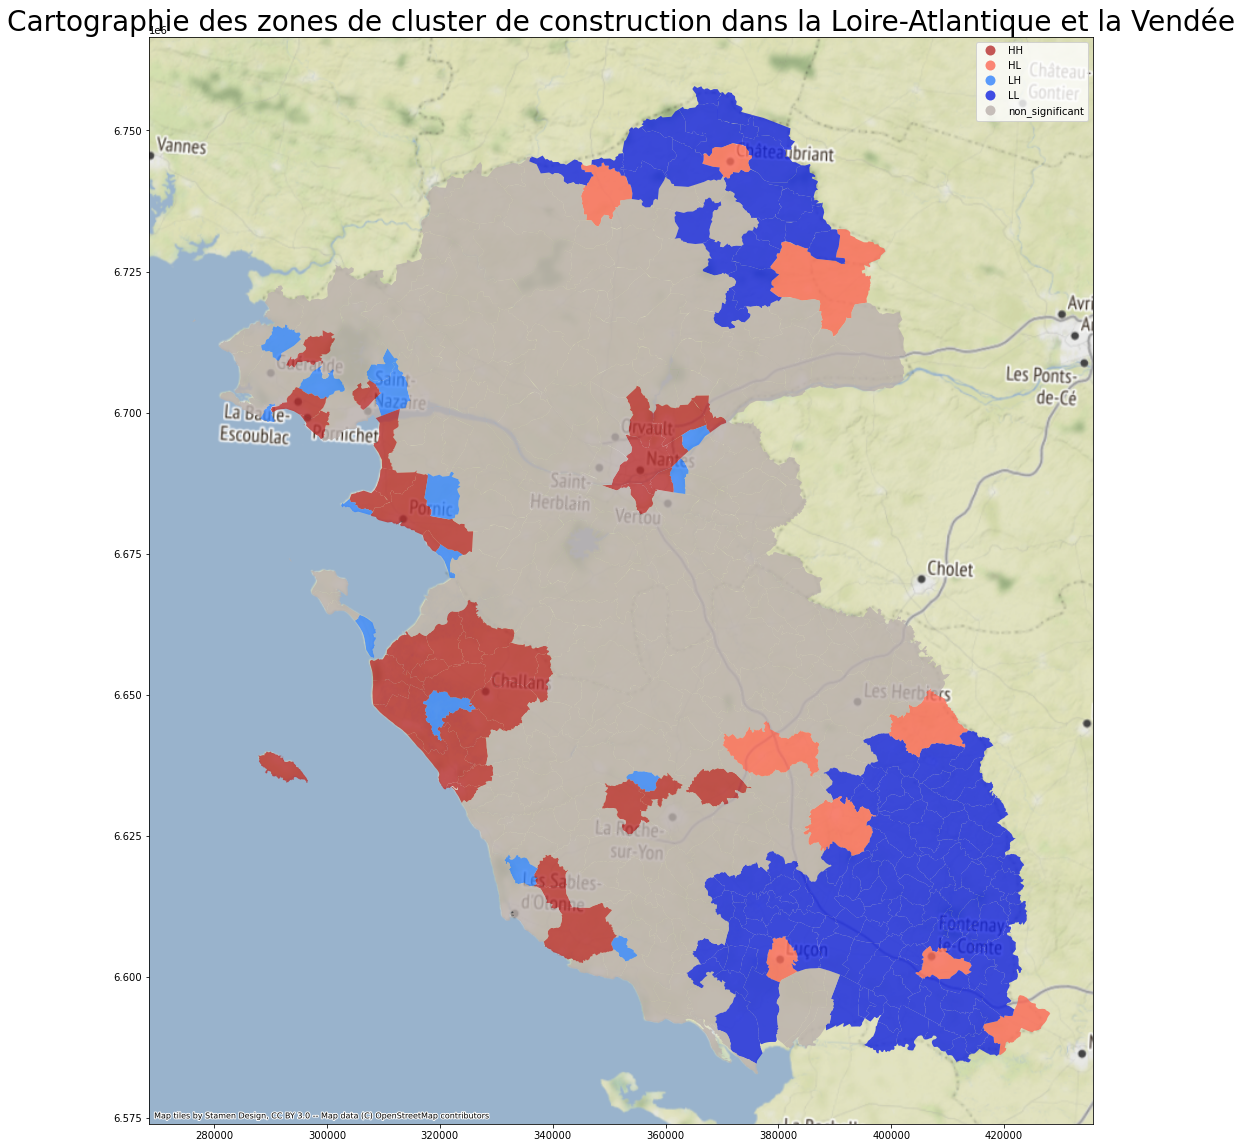

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44_85.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans la Loire-Atlantique et la Vendée", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44_85.crs)

### Moran Index with contiguity matrix

In [69]:
o=ps.lib.weights.Queen.from_dataframe(dep_44_85, geom_col='geometry')

C:\Users\Thomas\Anaconda3\envs\geo\lib\site-packages\pysal\lib\weights\contiguity.py:185: UserWarning:

There is one disconnected observation (no neighbors).
Island id: 390



In [70]:
m=ps.explore.esda.Moran(y, o)

('WARNING: ', 390, ' is an island (no neighbors)')


#### global

In [71]:
print('moran global')
print(m.I)

moran global
0.31893564630553195


#### local

In [72]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

In [73]:
dep_44_85['index_moran_classe_contiguity']=m_local.q
dep_44_85['index_moran_contiguity']=m_local.Is

#### test de randomisation

In [74]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


#### false discovery rate

In [75]:
test=ps.explore.esda.fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster_contiguity']=dep_44_85['index_moran_classe_contiguity'].where(dep_44_85['p_value'] <= test).fillna(0)

In [76]:
dep_44_85['index_moran_cluster_contiguity']=dep_44_85['index_moran_cluster_contiguity'].apply(lambda x: moran_cluster(x))

#### cartographie cluser

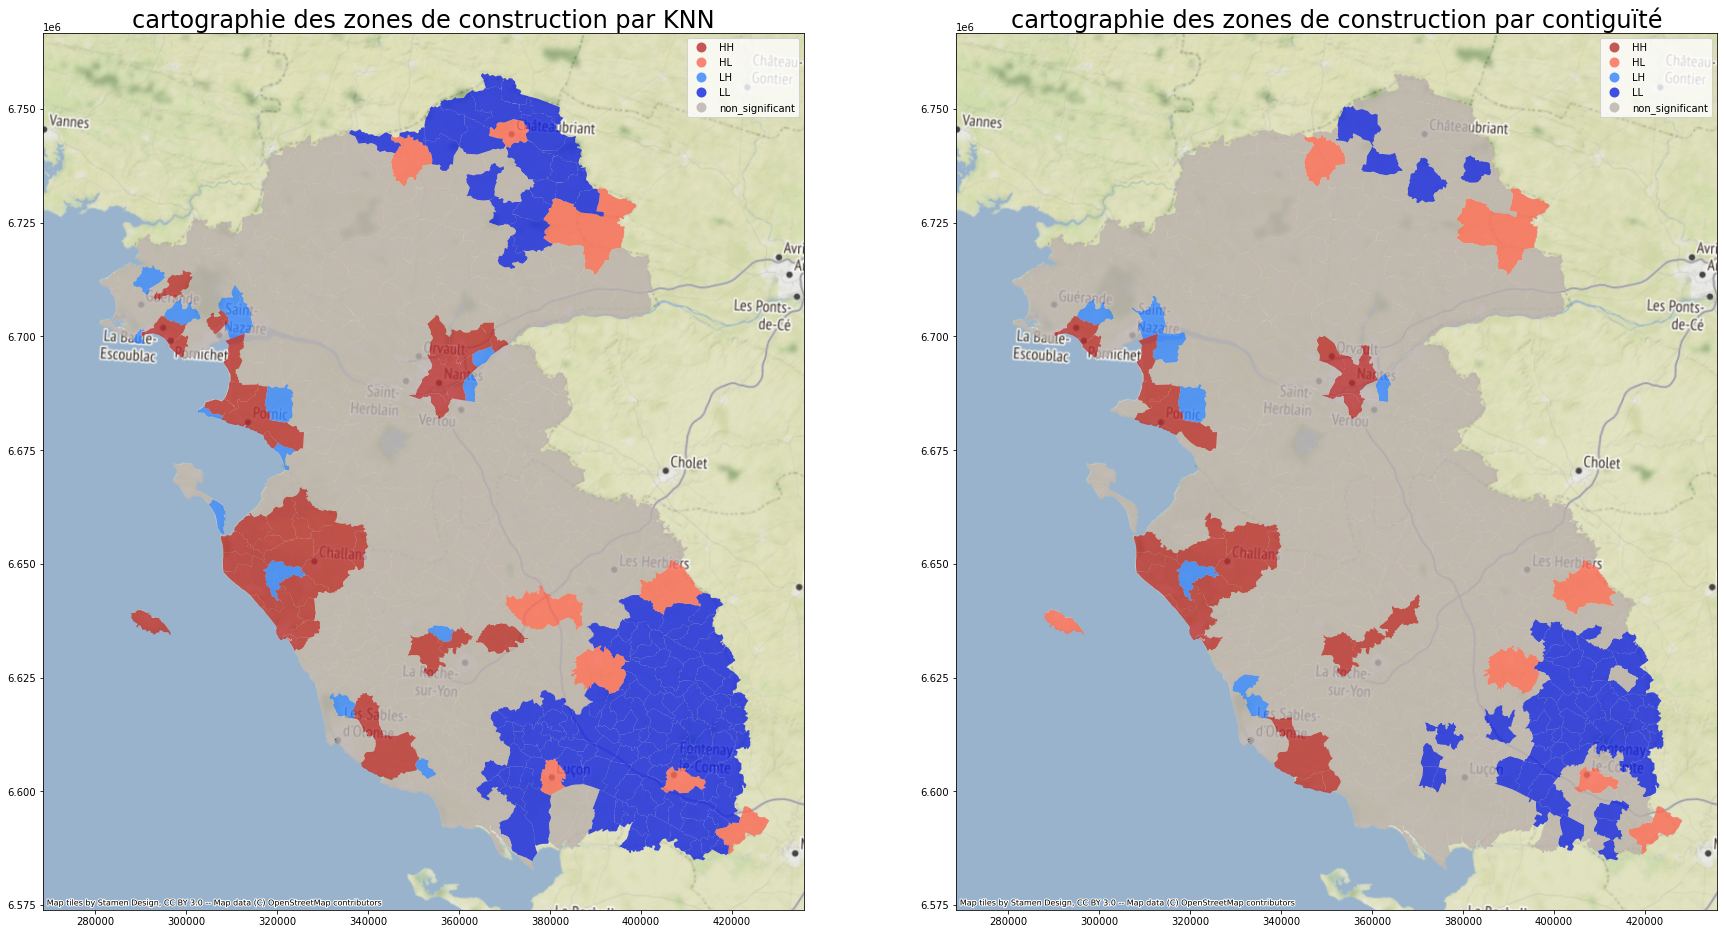

In [77]:

###definition du cadre
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))

##ax1.axis('off')
#ax2.axis('off')
### name of graphics
ax1.set_title('cartographie des zones de construction par KNN', fontsize=24)
ax2.set_title('cartographie des zones de construction par contiguïté', fontsize=24)

###graphic matrix knn
ax1=dep_44_85.plot(ax=ax1,column='index_moran_cluster',legend=True, alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())));
cx.add_basemap(ax1, crs=dep_44_85.crs)

###graphic matrix contiguity
ax2=dep_44_85.plot(ax=ax2,column='index_moran_cluster_contiguity',legend=True, alpha=0.8,
              cmap=colors.ListedColormap(list(color_dict.values())));
cx.add_basemap(ax2, crs=dep_44_85.crs)


plt.show()


## En conclusion


## Discussion

Notre étude est limitée car elle prend uniquement en compte les constructions alors que l'étude de l'extension urbaine ne se réduit pas uniquement à ce prisme.
En effet beaucoup d'autres facteurs rentrent en compte: l'augmentation du prix du mètre carré, le type de construction (immeuble ou maison par exemple), l'évoultion sociologique des populations...

##### 